Load Packages and settings

In [1]:
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import r2_score
import xarray as xr

#select particular representative gauge
reg = 'SR'

if reg == 'CT':
    columnname = str(54)
    mask_size = '892'
elif reg == 'SR':
    columnname = str(38)
    mask_size = '961'

MLDir = '/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami' 
SimDir = "/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/simu/"

list_size = ['961','1773','3669','6941']
mask_size = list_size[0]
train_size = list_size[1]

/tmp/ipykernel_2306659/3774323924.py:22: DtypeWarning: Columns (6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  master_info = pd.read_csv(f'{MLDir}/resources/processed/allinfo_eventsBS_PS53550.csv',sep=',')


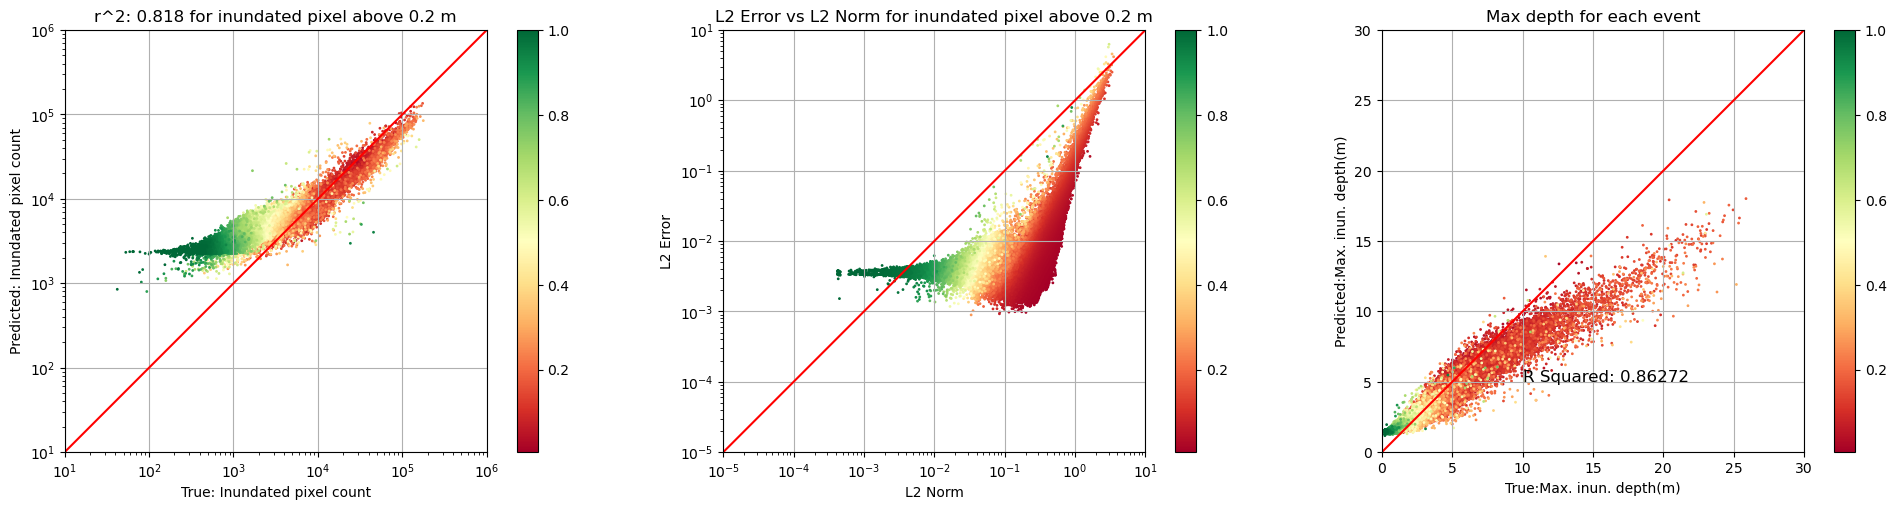

In [4]:
    MLDir = '/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami' 
    perf_df_list = []
    loc_df_list = []
    for test_size in ['0', '1', '2', '3']:
        #read test performance events and append together rows to single dataframe
        file_perf = f'{MLDir}/model/{reg}/out/model_nodeform_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_testsize{test_size}.csv'
        file_loc = f'{MLDir}/model/{reg}/out/model_nodeform_off[64, 128, 256]_on[16, 128, 128]_{train_size}_true_pred_er_testsize{test_size}.csv'
        df1 = pd.read_csv(file_perf)
        df2 = pd.read_csv(file_loc)
        perf_df_list.append(df1)
        loc_df_list.append(df2)

    perf_df = pd.concat(perf_df_list, ignore_index=True)
    loc_df = pd.concat(loc_df_list, ignore_index=True)
    #read train events to mark test or train
    train_file = f'{MLDir}/data/events/shuffled_events_{reg}_{train_size}.txt'
    train_eve = np.loadtxt(train_file, dtype='str')
    perf_df['split'] = np.where(perf_df['id'].isin(train_eve), 'train', 'test')
    loc_df['split'] = np.where(loc_df['id'].isin(train_eve), 'train', 'test')
    
    #read master info file to add more columns
    master_info = pd.read_csv(f'{MLDir}/resources/processed/allinfo_eventsBS_PS53550.csv',sep=',')
    master_info = master_info.rename(columns={'ID':'eve_id'})
    SR_info = pd.read_csv(f'{MLDir}/resources/processed/eve_PS_SourceRegion.txt',sep='\t')
    SR_info.rename(columns={'ID':'eve_id'},inplace=True)
    perf_df['Mag'] = perf_df['eve_id'].map(master_info.set_index('eve_id')['Mag'])
    perf_df['SR'] = perf_df['eve_id'].map(SR_info.set_index('eve_id')['SR'])
    perf_df['SR'].fillna('BS',inplace=True)   
    
    perf_df.to_csv(f'{MLDir}/model/{reg}/out/model_nodeform_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv', header=True, index=None)
    loc_df.to_csv(f'{MLDir}/model/{reg}/out/model_nodeform_off[64, 128, 256]_on[16, 128, 128]_{train_size}_true_pred_er_combined.csv', header=True, index=None)


    eve_perf = pd.read_csv(f'{MLDir}/model/{reg}/out/model_nodeform_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')
    eve_perf = eve_perf.sort_values(by='g',ascending=True)
    # Create a single figure with three axes
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    # Plot scatter of flood count
    r2area = r2_score(eve_perf['true'], eve_perf['pred'])
    scatter = ax[0].scatter(eve_perf['true'], eve_perf['pred'], s=1, c=eve_perf['g'], cmap='RdYlGn')
    ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, color='red')
    ax[0].set_title(f"r^2: {r2area:.3f} for inundated pixel above 0.2 m")
    plt.colorbar(scatter, ax=ax[0])
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlim(10, 1000000)
    ax[0].set_ylim(10, 1000000)
    ax[0].grid()
    ax[0].set_xlabel('True: Inundated pixel count')
    ax[0].set_ylabel('Predicted: Inundated pixel count')

    # Plot scatter of mse vs l2norm
    scatter = ax[1].scatter(eve_perf['l2n'], eve_perf['mse'], s=1, c=eve_perf['g'], cmap='RdYlGn')
    ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes, color='red')
    plt.colorbar(scatter, ax=ax[1])
    ax[1].set_title(f"L2 Error vs L2 Norm for inundated pixel above 0.2 m")
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlim(.00001, 10)
    ax[1].set_ylim(.00001, 10)
    ax[1].grid()
    ax[1].set_xlabel('L2 Norm')
    ax[1].set_ylabel('L2 Error')

    # Plot scatter of max depth for each event
    # Calculate the point density
    x = eve_perf['truemax']
    y = eve_perf['predmax']
    r2maxdepth = r2_score(x, y)
    scatter = ax[2].scatter(x, y, s=1, c=eve_perf['g'], cmap='RdYlGn')#c=z,
    ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes, color='red')
    plt.colorbar(scatter, ax=ax[2])
    ax[2].set_title("Max depth for each event")
    ax[2].text(10, 5, f"R Squared: {r2maxdepth:.5f} ", fontsize=12)
    ax[2].set_aspect('equal', adjustable='box')
    ax[2].set_xlim(0, 30)
    ax[2].set_ylim(0, 30)
    ax[2].grid()
    plt.xlabel('True:Max. inun. depth(m)')
    plt.ylabel('Predicted:Max. inun. depth(m)')

    # Adjust layout and add a suptitle to the main plot
    plt.tight_layout()
    # plt.suptitle(f"mseoverall: {mseoverall:.5f}, r2maxdepth: {r2maxdepth:.5f}, gfitoverall: {gfitoverall:.4f}, testsize: {self.test_size}", fontsize=16, y=0.02)
    plt.savefig(f'{MLDir}/model/{reg}/out/model_nodeform_[64, 128, 256]_on[16, 128, 128]_{train_size}_combined.png')


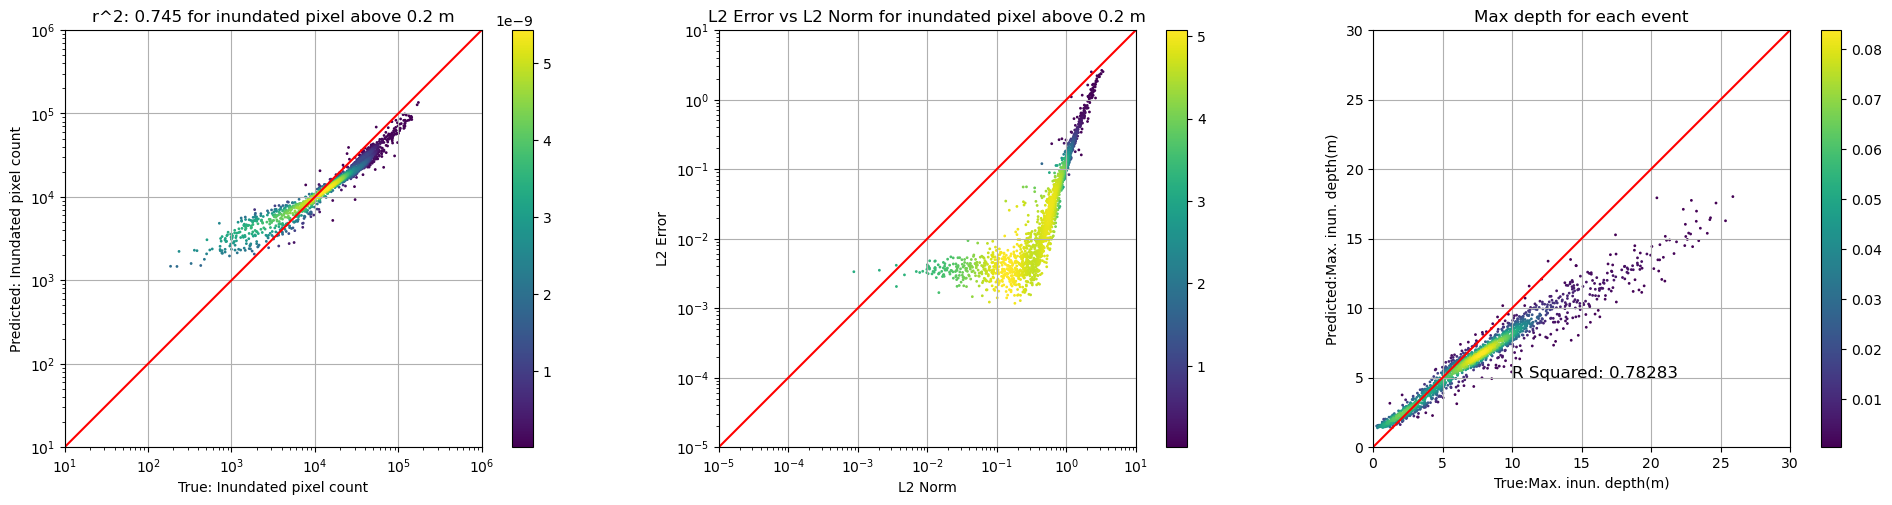

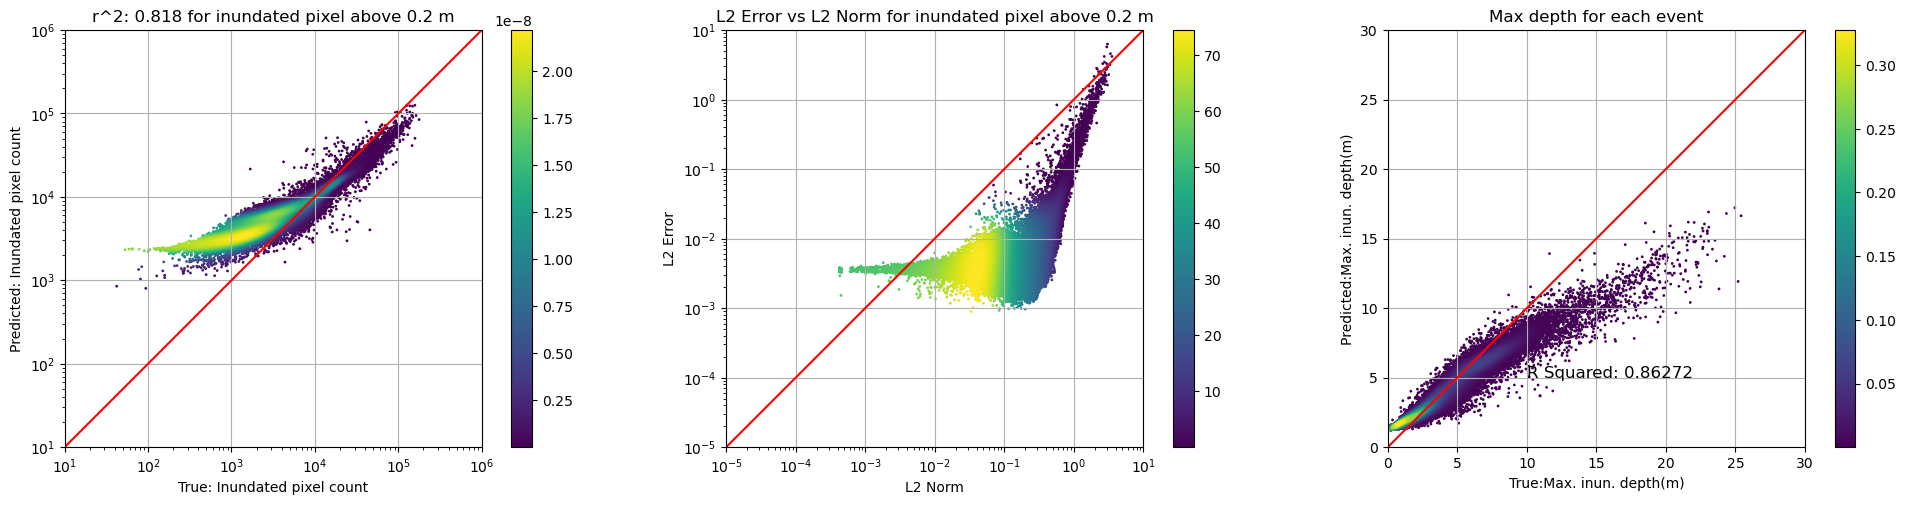

In [2]:
for split in ['train', 'test']:
    eve_perf = pd.read_csv(f'{MLDir}/model/{reg}/out/model_nodeform_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')
    # Create a single figure with three axes
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    # Plot scatter of flood count
    #select only rows where split is train or test
    x = eve_perf[eve_perf['split'] == split]['true']
    y = eve_perf[eve_perf['split'] == split]['pred']
    x.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    r2area = r2_score(x, y)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    index = z.argsort()
    x, y, z = x[index], y[index], z[index]
    scatter = ax[0].scatter(x, y, c=z, s=1)
    ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, color='red')
    ax[0].set_title(f"r^2: {r2area:.3f} for inundated pixel above 0.2 m")
    plt.colorbar(scatter, ax=ax[0])
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlim(10, 1000000)
    ax[0].set_ylim(10, 1000000)
    ax[0].grid()
    ax[0].set_xlabel('True: Inundated pixel count')
    ax[0].set_ylabel('Predicted: Inundated pixel count')

    # Plot scatter of mse vs l2norm
    # Calculate the point density
    x = eve_perf[eve_perf['split'] == split]['l2n']
    y = eve_perf[eve_perf['split'] == split]['mse']
    x.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    index = z.argsort()
    x, y, z = x[index], y[index], z[index]
    scatter = ax[1].scatter(x, y, c=z, s=1)
    ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes, color='red')
    plt.colorbar(scatter, ax=ax[1])
    ax[1].set_title(f"L2 Error vs L2 Norm for inundated pixel above 0.2 m")
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlim(.00001, 10)
    ax[1].set_ylim(.00001, 10)
    ax[1].grid()
    ax[1].set_xlabel('L2 Norm')
    ax[1].set_ylabel('L2 Error')

    # Plot scatter of max depth for each event
    # Calculate the point density
    x = eve_perf[eve_perf['split'] == split]['truemax']
    y = eve_perf[eve_perf['split'] == split]['predmax']
    x.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    r2maxdepth = r2_score(x, y)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    index = z.argsort()
    x, y, z = x[index], y[index], z[index]
    scatter = ax[2].scatter(x, y, c=z, s=1)
    ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes, color='red')
    plt.colorbar(scatter, ax=ax[2])
    ax[2].set_title("Max depth for each event")
    ax[2].text(10, 5, f"R Squared: {r2maxdepth:.5f} ", fontsize=12)
    ax[2].set_aspect('equal', adjustable='box')
    ax[2].set_xlim(0, 30)
    ax[2].set_ylim(0, 30)
    ax[2].grid()
    plt.xlabel('True:Max. inun. depth(m)')
    plt.ylabel('Predicted:Max. inun. depth(m)')

    # Adjust layout and add a suptitle to the main plot
    plt.tight_layout()

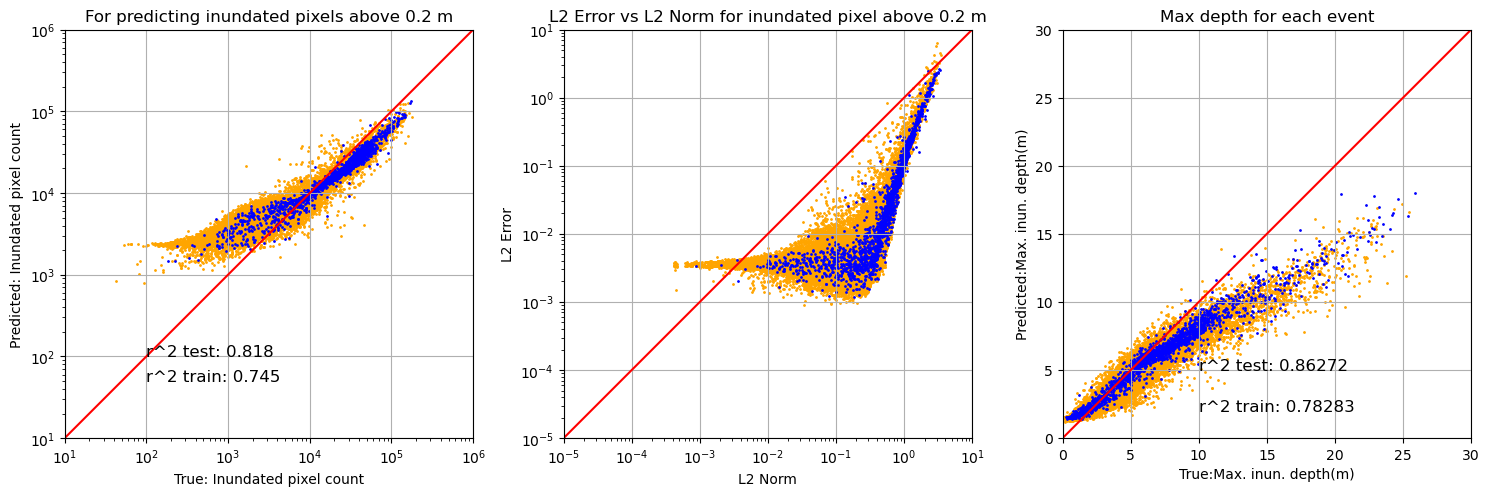

In [7]:
    eve_perf = pd.read_csv(f'{MLDir}/model/{reg}/out/model_nodeform_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')

    # Create a single figure with three axes
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Plot scatter of flood count
    x = eve_perf[eve_perf['split'] == 'test']['true']
    y = eve_perf[eve_perf['split'] == 'test']['pred']
    r2area = r2_score(x, y)
    scatter = ax[0].scatter(x, y, s=1,label='test', c='orange')
    #add r2 score at bottom right of axis
    ax[0].text(100,100,f"r^2 test: {r2area:.3f} ", fontsize=12)

    x = eve_perf[eve_perf['split'] == 'train']['true']
    y = eve_perf[eve_perf['split'] == 'train']['pred']
    r2area = r2_score(x, y)
    scatter = ax[0].scatter(x, y, s=1,label='train', c='blue')
    ax[0].text(100,50,f"r^2 train: {r2area:.3f} ", fontsize=12)
    
    ax[0].title.set_text(f"For predicting inundated pixels above 0.2 m")
    ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, color='red')
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlim(10, 1000000)
    ax[0].set_ylim(10, 1000000)
    ax[0].grid()
    ax[0].set_xlabel('True: Inundated pixel count')
    ax[0].set_ylabel('Predicted: Inundated pixel count')

    # Plot scatter of mse vs l2norm
    x = eve_perf[eve_perf['split'] == 'test']['l2n']
    y = eve_perf[eve_perf['split'] == 'test']['mse']
    scatter = ax[1].scatter(x, y, s=1,label='test', c='orange')

    x = eve_perf[eve_perf['split'] == 'train']['l2n']
    y = eve_perf[eve_perf['split'] == 'train']['mse']
    scatter = ax[1].scatter(x, y, s=1,label='train', c='blue')
    
    ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes, color='red')
    ax[1].set_title(f"L2 Error vs L2 Norm for inundated pixel above 0.2 m")
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlim(.00001, 10)
    ax[1].set_ylim(.00001, 10)
    ax[1].grid()
    ax[1].set_xlabel('L2 Norm')
    ax[1].set_ylabel('L2 Error')

    # Plot scatter of max depth for each event
    # Calculate the point density
   
    x = eve_perf[eve_perf['split'] == 'test']['truemax']
    y = eve_perf[eve_perf['split'] == 'test']['predmax']
    scatter = ax[2].scatter(x, y, s=1,label='test', c='orange')
    r2maxdepth = r2_score(x, y)
    ax[2].text(10, 5, f"r^2 test: {r2maxdepth:.5f} ", fontsize=12)

    x = eve_perf[eve_perf['split'] == 'train']['truemax']
    y = eve_perf[eve_perf['split'] == 'train']['predmax']
    scatter = ax[2].scatter(x, y, s=1,label='train', c='blue')
    r2maxdepth = r2_score(x, y)
    ax[2].text(10, 2, f"r^2 train: {r2maxdepth:.5f} ", fontsize=12)

    ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes, color='red')
    ax[2].set_title("Max depth for each event")
    ax[2].set_aspect('equal', adjustable='box')
    ax[2].set_xlim(0, 30)
    ax[2].set_ylim(0, 30)
    ax[2].grid()
    plt.xlabel('True:Max. inun. depth(m)')
    plt.ylabel('Predicted:Max. inun. depth(m)')

    # Adjust layout and add a suptitle to the main plot
    plt.tight_layout()


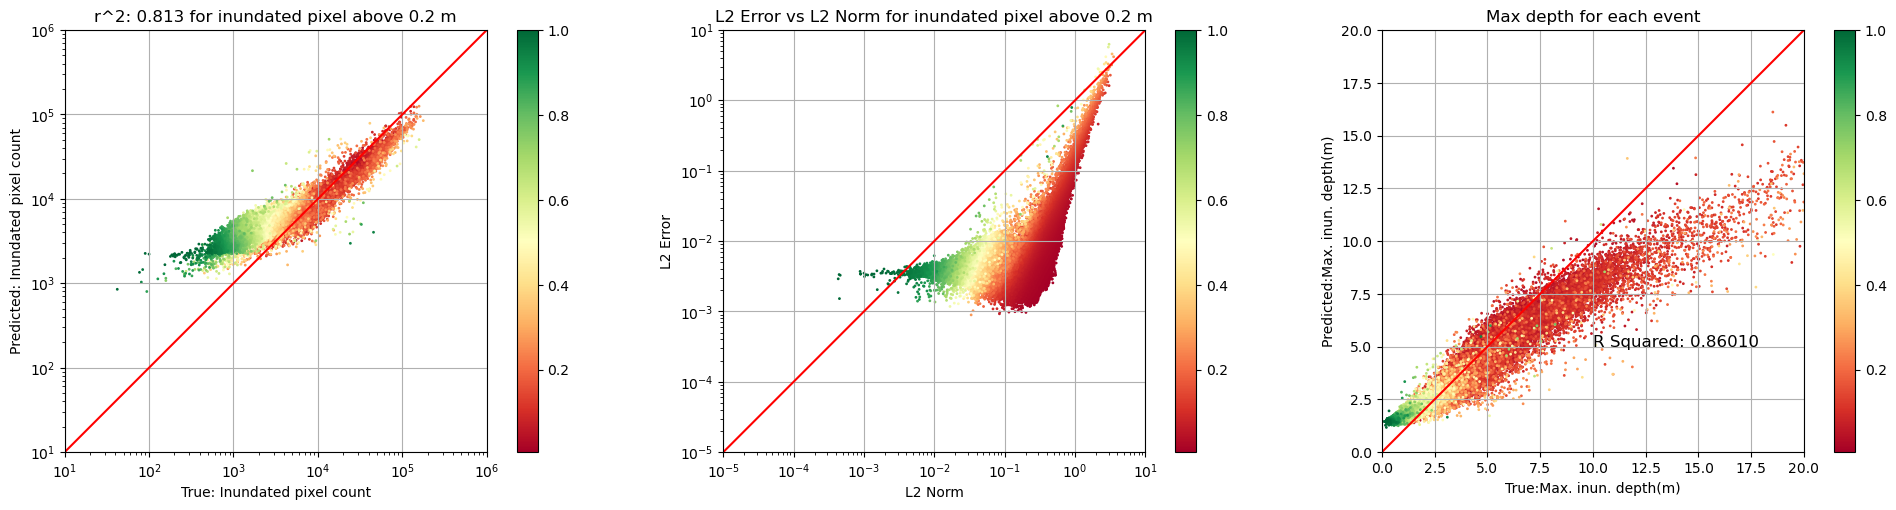

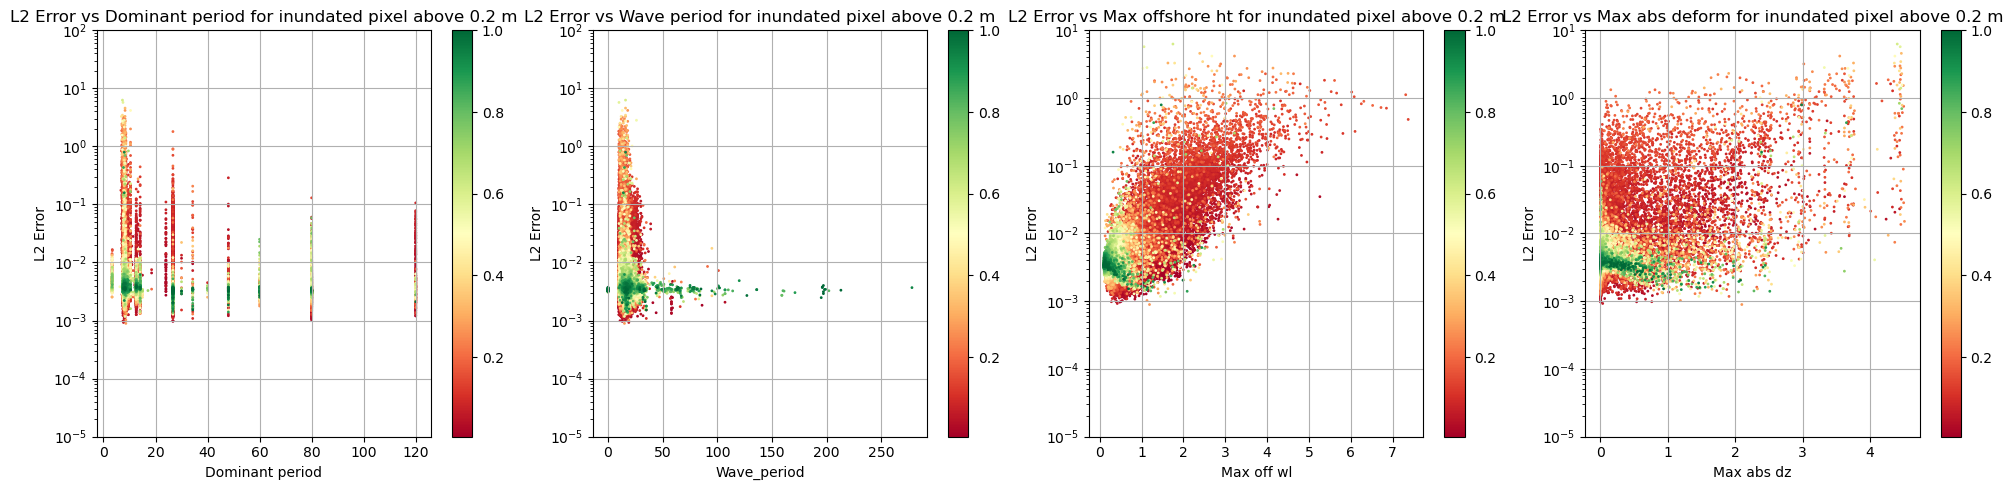

In [8]:
eve_perf = pd.read_csv(f'{MLDir}/model/{reg}/out/model_nodeform_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')
eve_perf = eve_perf[eve_perf['split']== 'test']
eve_perf = eve_perf[eve_perf['max_off']>0.1]
eve_perf = eve_perf[eve_perf['max_off']>0.1]
eve_perf = eve_perf.sort_values(by='g',ascending=True)
eve_perf.reset_index(drop=True, inplace=True)
#filter events with G greater than 0.3  or r2 less than 0.7
# eve_perf = eve_perf[(eve_perf['g']>0.3)] #
# print('events with G greater than 0.3',len(eve_perf))

# Create a single figure with three axes
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot scatter of flood count
r2area = r2_score(eve_perf['true'], eve_perf['pred'])
scatter = ax[0].scatter(eve_perf['true'], eve_perf['pred'], s=1, c=eve_perf['g'], cmap='RdYlGn')
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, color='red')
ax[0].set_title(f"r^2: {r2area:.3f} for inundated pixel above 0.2 m")
plt.colorbar(scatter, ax=ax[0])
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(10, 1000000)
ax[0].set_ylim(10, 1000000)
ax[0].grid()
ax[0].set_xlabel('True: Inundated pixel count')
ax[0].set_ylabel('Predicted: Inundated pixel count')

# Plot scatter of mse vs l2norm
scatter = ax[1].scatter(eve_perf['l2n'], eve_perf['mse'], s=1, c=eve_perf['g'], cmap='RdYlGn')
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes, color='red')
plt.colorbar(scatter, ax=ax[1])
ax[1].set_title(f"L2 Error vs L2 Norm for inundated pixel above 0.2 m")
ax[1].set_aspect('equal', adjustable='box')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim(.00001, 10)
ax[1].set_ylim(.00001, 10)
ax[1].grid()
ax[1].set_xlabel('L2 Norm')
ax[1].set_ylabel('L2 Error')

# Plot scatter of max depth for each event
# Calculate the point density
eve_perf.reset_index(drop=True, inplace=True) #reset index
x = eve_perf['truemax']
y = eve_perf['predmax']
z = eve_perf['g']
r2maxdepth = r2_score(x, y)
scatter = ax[2].scatter(x, y, c=z, s=1, cmap='RdYlGn')
ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes, color='red')
plt.colorbar(scatter, ax=ax[2])
ax[2].set_title("Max depth for each event")
ax[2].text(10, 5, f"R Squared: {r2maxdepth:.5f} ", fontsize=12)
ax[2].set_aspect('equal', adjustable='box')
ax[2].set_xlim(0, 20)
ax[2].set_ylim(0, 20)
ax[2].grid()
plt.xlabel('True:Max. inun. depth(m)')
plt.ylabel('Predicted:Max. inun. depth(m)')

# Adjust layout and add a suptitle to the main plot
plt.tight_layout()


# Create a single figure with three axes
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Plot scatter of mse vs dominant wp
scatter = ax[0].scatter(eve_perf['dominant_period'], eve_perf['mse'], s=1, c=eve_perf['g'], cmap='RdYlGn')
# ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, color='red')
plt.colorbar(scatter, ax=ax[0])
ax[0].set_title(f"L2 Error vs Dominant period for inundated pixel above 0.2 m")
# ax[0].set_aspect('equal', adjustable='box')
# ax[0].set_xscale('log')
ax[0].set_yscale('log')
# ax[0].set_xlim(.00001, 100)
ax[0].set_ylim(.00001, 100)
ax[0].grid()
ax[0].set_xlabel('Dominant period')
ax[0].set_ylabel('L2 Error')

# Plot scatter of mse vs dominant wp
scatter = ax[1].scatter(eve_perf['wave_period'], eve_perf['mse'], s=1, c=eve_perf['g'], cmap='RdYlGn')
# ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes, color='red')
plt.colorbar(scatter, ax=ax[1])
ax[1].set_title(f"L2 Error vs Wave period for inundated pixel above 0.2 m")
# ax[1].set_aspect('equal', adjustable='box')
# ax[1].set_xscale('log')
ax[1].set_yscale('log')
# ax[1].set_xlim(.00001, 100)
ax[1].set_ylim(.00001, 100)
ax[1].grid()
ax[1].set_xlabel('Wave_period')
ax[1].set_ylabel('L2 Error')

# Plot scatter of mse vs max_off
scatter = ax[2].scatter(eve_perf['max_off'], eve_perf['mse'], s=1, c=eve_perf['g'], cmap='RdYlGn')
# ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes, color='red')
plt.colorbar(scatter, ax=ax[2])
ax[2].set_title(f"L2 Error vs Max offshore ht for inundated pixel above 0.2 m")
# ax[2].set_aspect('equal', adjustable='box')
# ax[2].set_xscale('log')
ax[2].set_yscale('log')
# ax[2].set_xlim(.00001, 100)
ax[2].set_ylim(.00001, 10)
ax[2].grid()
ax[2].set_xlabel('Max off wl')
ax[2].set_ylabel('L2 Error')

# Plot scatter of mse vs max_absdz
scatter = ax[3].scatter(eve_perf['max_absdz'], eve_perf['mse'], s=1, c=eve_perf['g'], cmap='RdYlGn')
# ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes, color='red')
plt.colorbar(scatter, ax=ax[3])
ax[3].set_title(f"L2 Error vs Max abs deform for inundated pixel above 0.2 m")
# ax[2].set_aspect('equal', adjustable='box')
# ax[2].set_xscale('log')
ax[3].set_yscale('log')
# ax[2].set_xlim(.00001, 100)
ax[3].set_ylim(.00001, 10)
ax[3].grid()
ax[3].set_xlabel('Max abs dz')
ax[3].set_ylabel('L2 Error')

# Adjust layout and add a suptitle to the main plot
plt.tight_layout()


[29720, 202349, 153030, 94497]
Control Location:1,No of flood events:2903/53550
Control Location:2,No of flood events:28895/53550
Control Location:3,No of flood events:6602/53550
Control Location:4,No of flood events:10843/53550


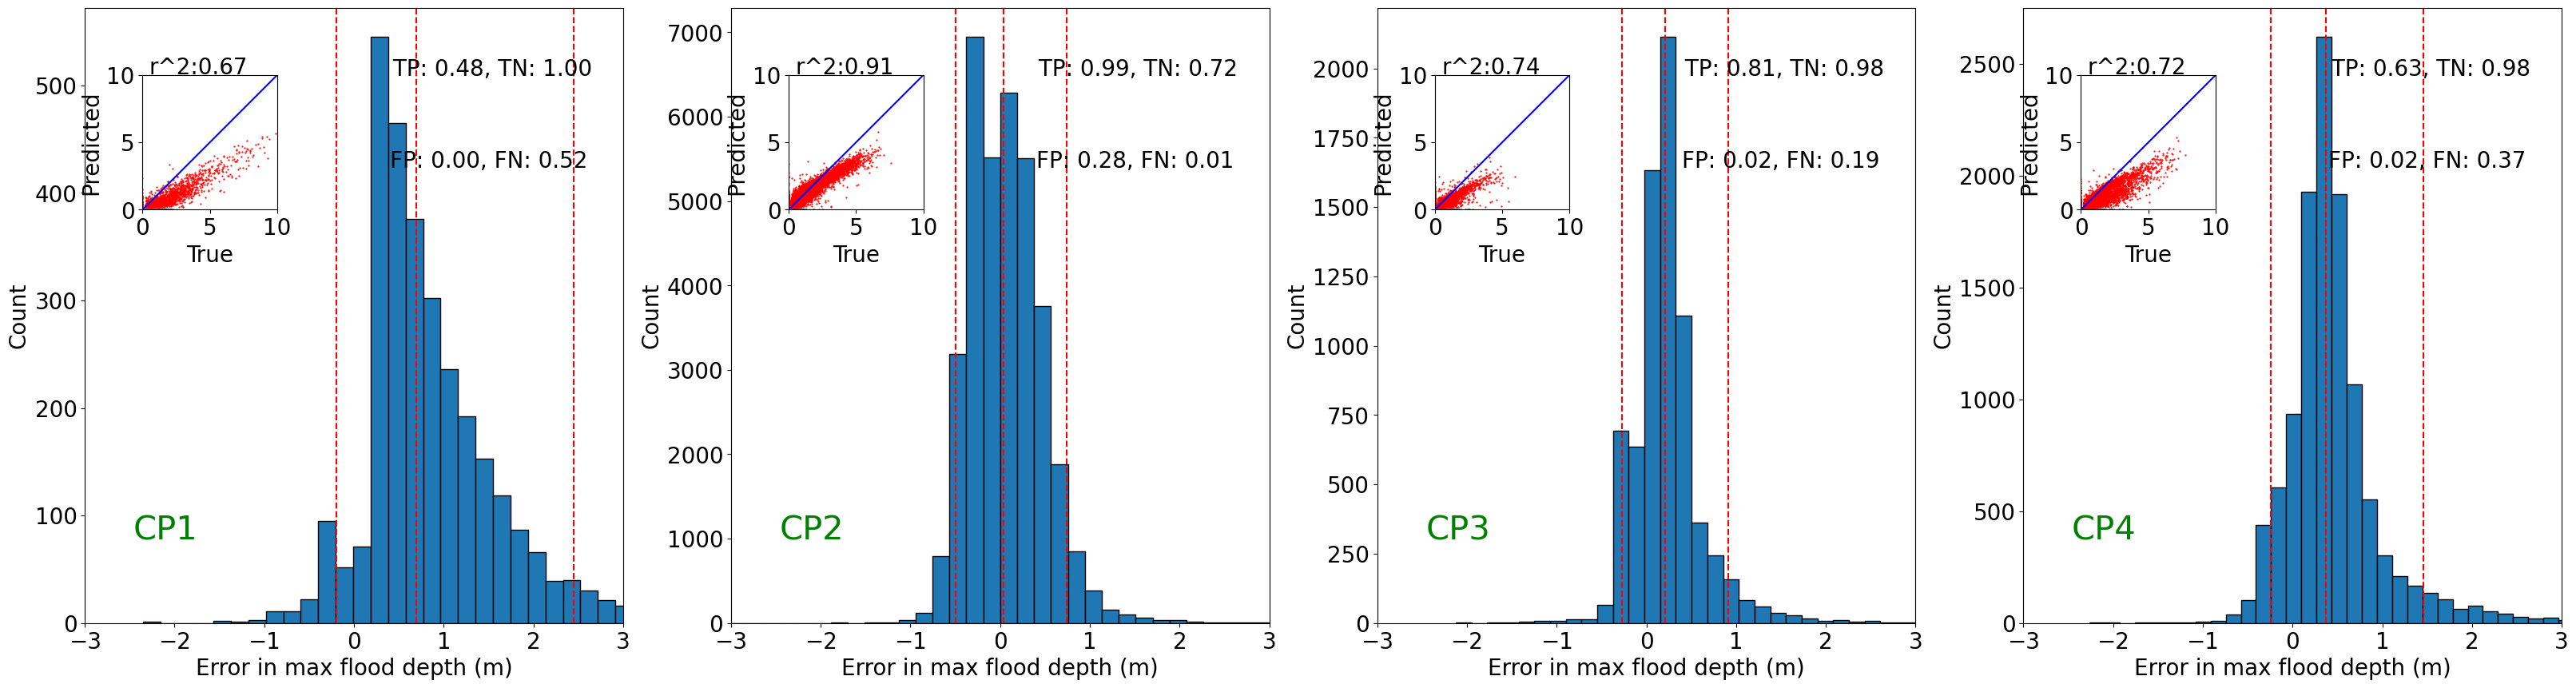

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import xarray as xr

def get_idx_from_latlon(locations,reg,MLDir,SimDir,mask_size):  
    #get first event to get lat lon
    firstevent = np.loadtxt(f'{MLDir}/data/events/sample_events53550.txt',dtype='str')[0]
    D_grids = xr.open_dataset(f'{SimDir}/{firstevent}/{reg}_flowdepth.nc')
    zero_mask = np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
    non_zero_list = np.argwhere(~zero_mask).tolist()

    #iterate over list locations
    indices = []
    for loc in locations: 
        #get index of lat lon
        lat_idx = np.argmin(np.abs(D_grids.lat.values - loc[0]))
        lon_idx = np.argmin(np.abs(D_grids.lon.values - loc[1]))

        #get idx in non zero mask list from lat_idx and lon_idx
        idx = non_zero_list.index([lat_idx,lon_idx])
        indices.append(idx)

    # return lat_idx, lon_idx, idx
    print(indices)
    return indices

threshold = 0.2
control_points = [[37.01,15.29],
            [37.06757,15.28709],
            [37.05266,15.26536],
            [37.03211,15.28632]]
#[587734, 575410, 543846, 520437, 519950, 494033, 410933, 329708, 233614, 158611, 83994, 314698]

#keep every second element from the list
# control_points = control_points[::1]
locindices = get_idx_from_latlon(control_points,reg,MLDir,SimDir,mask_size)

true_pred_er = pd.read_csv(f'{MLDir}/model/{reg}/out/model_nodeform_off[64, 128, 256]_on[16, 128, 128]_{train_size}_true_pred_er_combined.csv')
#keep every second column from the dataframe
# true_pred_er = true_pred_er.iloc[:,::2]
#filter all columns with column name starting with E of true_pred_er
er_list = true_pred_er.iloc[:,true_pred_er.columns.str.startswith('E')].values 
#remove first and last column 
true_pred_er = true_pred_er.iloc[:,1:-1].values

#error charts
plt.figure(figsize=(40, 10))
for i in range(len(locindices)):
    ax = plt.subplot(1, 4, i+1)
    # Plot the histogram of errors for the control locations
    plt.hist(er_list[er_list[:,i]!=0,i],bins=40,edgecolor='black',)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    # Check if its empty
    if len(er_list[er_list[:,i]!=0,i]) == 0:
        continue
    else:
        quantiles = np.percentile(er_list[er_list[:,i]!=0,i], [5, 50, 95])
        # Plot quantile lines
        for q in quantiles:
            ax.axvline(q, color='red', linestyle='--', label=f'Q{int(q)}')
        ax.set_xlim(-3, 3)
    #calculate hit and mis for each location based on depth of true and prediction
    #events crossing the threshold say 0.2 are considered flooded
    neve = np.count_nonzero(true_pred_er[:,i]>threshold)
    neve_recon = np.count_nonzero(true_pred_er[:,i+len(locindices)]>threshold)
    print(f"Control Location:{i+1},No of flood events:{neve}/{len(true_pred_er[:,i])}")
    if neve == 0:
        TP = -999
        FN = -999
    else:
    #true positive: true>0.2 and pred>0.2
        TP = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+len(locindices)]>threshold))/(neve)
        FN = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+len(locindices)]<=threshold))/(neve)
    TN = np.count_nonzero((true_pred_er[:,i]<=threshold) & (true_pred_er[:,i+len(locindices)]<=threshold))/(len(true_pred_er[:,i])-neve)
    FP = np.count_nonzero((true_pred_er[:,i]<=threshold) & (true_pred_er[:,i+len(locindices)]>threshold))/(len(true_pred_er[:,i])-neve)
    # plt.title(f"#flood events:True={neve}|Predicted={neve_recon}",fontsize=20)
    plt.text(0.15,0.15,f"CP{i+1}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=30,color='green')
    plt.text(0.75, 0.9, f" TP: {TP:.2f}, TN: {TN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=20)
    plt.text(0.75, 0.75, f"FP: {FP:.2f}, FN: {FN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=20)
    plt.xlabel('Error in max flood depth (m)',fontsize=20)
    plt.ylabel('Count',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    # Create a new inset axis for the scatter plot
    axins = inset_axes(ax, width="25%", height="25%", loc='upper left', borderpad=5.2)
    # Scatter plot of values (replace with your data)
    axins.plot([0, 1], [0, 1], transform=axins.transAxes, color='blue')
    axins.scatter(true_pred_er[:,i], true_pred_er[:,i+len(locindices)], marker='o', color='red', label='Max Inun Depth',s=0.33)  # Customize marker and color as needed
    axins.text(0.5,10.1,f'r^2:{r2_score(true_pred_er[:,i], true_pred_er[:,i+len(locindices)]):.2f}',fontsize=20)
    axins.set_xlim(0, 10)  # Adjust x-axis limits for the scatter plot
    axins.set_ylim(0, 10)  # Adjust y-axis limits for the scatter plot
    axins.set_xticks([0, 5, 10])  # Adjust x-axis ticks for the scatter plot
    axins.set_yticks([0, 5, 10])  # Adjust y-axis ticks for the scatter plot
    axins.set_xlabel('True',fontsize=20)
    axins.set_ylabel('Predicted',fontsize=20)
    axins.set_aspect('equal', adjustable='box')
    axins.tick_params(axis='x', labelsize=20)
    axins.tick_params(axis='y', labelsize=20)
plt.savefig(f'{MLDir}/model/{reg}/out/error_test_combined_{reg}_{train_size}_nodeform.png', transparent=False)


In [10]:
#read combined file :/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/model_nodeform_off[64, 128, 256]_on[16, 128, 128]_892_compile_combined.csv
combined = pd.read_csv(f'{MLDir}/model/{reg}/out/model_nodeform_off[64, 128, 256]_on[16, 128, 128]_{train_size}_compile_combined.csv')

#sort by mse
combined = combined.sort_values(by='mse',ascending=False)

#find 95th percentile mse 
percentile95 = combined['mse'].quantile(0.99)

#filter events with mse greater than 95th percentile
bad_events = combined[combined['mse']>percentile95]

#sort by mse and reset index
bad_events = bad_events.sort_values(by='mse',ascending=False)
bad_events.reset_index(drop=True, inplace=True)

#save bad events to a file
bad_events.to_csv(f'{MLDir}/model/{reg}/out/Q99_events_{reg}_{train_size}_nodeform.csv',index=False)


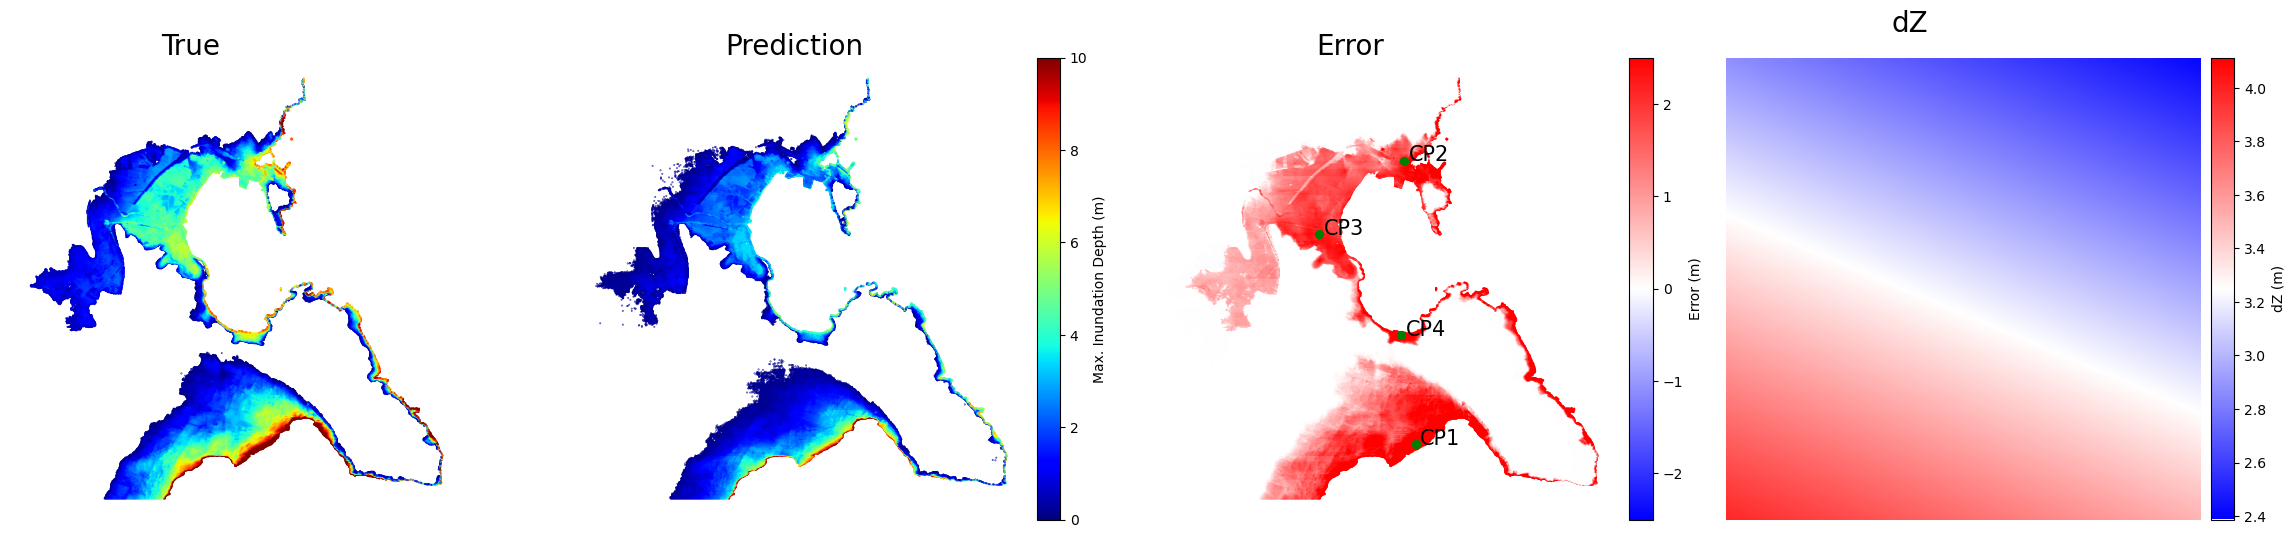

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import r2_score
import xarray as xr

#select particular representative gauge
reg = 'SR'
list_size = ['961','1773','3669','6941']
columnname = str(54)
mask_size = '961'
train_size = list_size[1]
test_size = 3
idx= np.load(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/processed/lat_lon_idx_{reg}_{mask_size}.npy')
#add recon and true column to to the idx array
n_eve = len(np.loadtxt(f'{MLDir}/data/events/shuffled_events_test_{reg}_{test_size}.txt', dtype='str'))
nflood_grids = len(idx)
red_d_array = np.memmap(f'{MLDir}/data/processed/dflat_{reg}_{test_size}.dat',
                        mode='r',
                        dtype=float,
                        shape=(n_eve, nflood_grids))

id = 8761 #BS_manning003/E01267N3753E01646N3535-BS-M809_E01551N3692_D010_S292D70R270_A006995_S075
eve_id = np.loadtxt(f'{MLDir}/data/events/shuffled_events_test_{reg}_{test_size}.txt', dtype='str')[id]

#read dZ file and grid location file to extract location information
data2plot = xr.open_dataset(f'{SimDir}/{eve_id}/{reg}_deformation.nc')
dz = data2plot['deformation'].values# (948 x 1300)
# x = data2plot['x'].values #1300
# y = data2plot['y'].values #948

x = np.linspace(0,dz.shape[1],dz.shape[1])
y = np.linspace(0,dz.shape[0],dz.shape[0])


#create list of x,y,dz
xy_mesh = np.meshgrid(x,y)
x_list,y_list = xy_mesh[0].flatten(),xy_mesh[1].flatten()
dz_list = dz.flatten()


true = red_d_array[id, :]
pred_test = f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/{reg}/out/pred_trainsize{train_size}_testsize{test_size}_nodeform.npy'
pred = np.load(pred_test)[id, :]
pred[np.isnan(pred)] = 0
error = true - pred

del red_d_array,pred_test

red_dZ_array = np.memmap(f'{MLDir}/data/processed/dZflat_{reg}_{test_size}.dat',
                            mode='r',
                            dtype=float,
                            shape=(n_eve, nflood_grids))
deform = red_dZ_array[id, :]
del red_dZ_array

idx = np.c_[idx,true,pred,error,deform]

# set values below 0.1 to nan
idx[idx[:,4] < 0.1, 4] = np.nan
idx[idx[:,5] < 0.1, 5] = np.nan

# Using enumerate to add index to the list of coordinates
control_points = [[37.01,15.29],
            [37.06757,15.28709],
            [37.05266,15.26536],
            [37.03211,15.28632]]

coordinates_list = pd.DataFrame(control_points,columns=['lat','lon'])
coordinates_list['id'] = coordinates_list.index+1
CP_list = [29720, 202349, 153030, 94497]
coordinates_list['idx'] = CP_list
coordinates_list['m'] = idx[CP_list, 1]
coordinates_list['n'] = idx[CP_list, 0]

# Plot the true, recon, and error values on the map as color side by side using lat lon
minval = 0
maxval = 10
minerror = -2.5
maxerror = 2.5

fig, axs = plt.subplots(1, 4, figsize=(30, 6))

#set background color as transparent
# fig.patch.set_facecolor('none')

# Plot True
sc1 = axs[0].scatter(idx[:, 1], idx[:, 0], c=idx[:, 4], s=0.1, cmap='jet', vmin=minval, vmax=maxval)
axs[0].text(600,1000,'True',fontsize=20)
axs[0].set_aspect('equal')
axs[0].set_axis_off()

# Plot Prediction
sc2 = axs[1].scatter(idx[:, 1], idx[:, 0], c=idx[:, 5], s=0.1, cmap='jet', vmin=minval, vmax=maxval)
axs[1].text(600,1000,'Prediction',fontsize=20)
axs[1].set_aspect('equal')
axs[1].set_axis_off()

# Plot Error
sc3 = axs[2].scatter(idx[:, 1], idx[:, 0], c=idx[:, 6], s=0.1, cmap='bwr', vmin=minerror, vmax=maxerror)
axs[2].text(600,1000,'Error',fontsize=20)
# Add the control points
axs[2].scatter(coordinates_list['m'],coordinates_list['n'], marker='o', s=33, c='green')
for i, txt in enumerate(coordinates_list['id']):
    axs[2].annotate('CP'+ str(txt), (coordinates_list['m'][i]+10,coordinates_list['n'][i]),fontsize=15)
axs[2].set_aspect('equal')
axs[2].set_axis_off()

# # Plot Deformation
# # sc4 = axs[3].scatter(idx[:, 1], idx[:, 0], c=idx[:, 7], s=0.1, cmap='bwr', vmin=minerror, vmax=maxerror)
sc4 = axs[3].scatter(x_list,y_list,c=dz_list,cmap='bwr')
axs[3].text(600,1000,'dZ',fontsize=20)
axs[3].set_aspect('equal')
axs[3].set_xlim(min(idx[:, 1]), max(idx[:, 1]))
axs[3].set_ylim(min(idx[:, 0]), max(idx[:, 0]))
axs[3].set_axis_off()

# Create a divider for the existing axes instance
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)  # Adjust the pad as needed
plt.colorbar(sc1, cax=cax2, orientation='vertical', label='Max. Inundation Depth (m)')

# Create a divider for the existing axes instance
divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes('right', size='5%', pad=0.1)  # Adjust the pad as needed
plt.colorbar(sc3, cax=cax3, orientation='vertical', label='Error (m)')

# Create a divider for the existing axes instance
divider1 = make_axes_locatable(axs[3])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)  # Adjust the pad as needed
plt.colorbar(sc4, cax=cax1, orientation='vertical', label='dZ (m)')

# Ensure equal height for subplots
plt.subplots_adjust(wspace=0, hspace=0)

#save as svg
# plt.savefig(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/{reg}/out/Q99eve_example_{reg}.png',dpi=150,transparent=False)
plt.show()

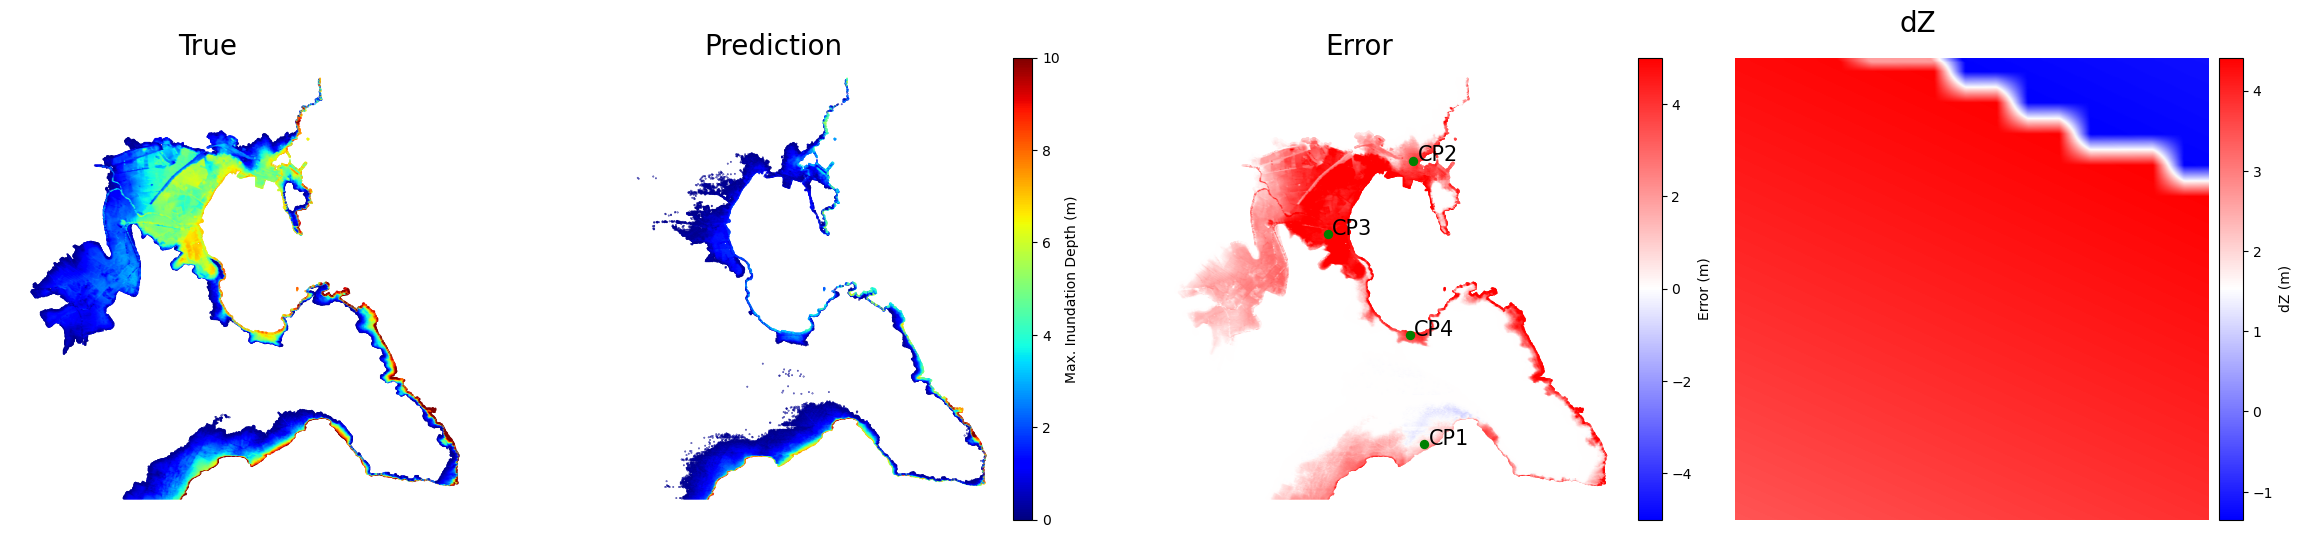

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import r2_score
import xarray as xr

#select particular representative gauge
reg = 'SR'
list_size = ['961','1773','3669','6941']
columnname = str(54)
mask_size = '961'
train_size = list_size[1]
test_size = 2
idx= np.load(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/processed/lat_lon_idx_{reg}_{mask_size}.npy')
#add recon and true column to to the idx array
n_eve = len(np.loadtxt(f'{MLDir}/data/events/shuffled_events_test_{reg}_{test_size}.txt', dtype='str'))
nflood_grids = len(idx)
red_d_array = np.memmap(f'{MLDir}/data/processed/dflat_{reg}_{test_size}.dat',
                        mode='r',
                        dtype=float,
                        shape=(n_eve, nflood_grids))

id = 2247 #BS_manning003/E01267N3753E01646N3535-BS-M809_E01551N3692_D010_S112D70R270_A006995_S075
eve_id = np.loadtxt(f'{MLDir}/data/events/shuffled_events_test_{reg}_{test_size}.txt', dtype='str')[id]

#read dZ file and grid location file to extract location information
data2plot = xr.open_dataset(f'{SimDir}/{eve_id}/{reg}_deformation.nc')
dz = data2plot['deformation'].values# (948 x 1300)
# x = data2plot['x'].values #1300
# y = data2plot['y'].values #948

x = np.linspace(0,dz.shape[1],dz.shape[1])
y = np.linspace(0,dz.shape[0],dz.shape[0])


#create list of x,y,dz
xy_mesh = np.meshgrid(x,y)
x_list,y_list = xy_mesh[0].flatten(),xy_mesh[1].flatten()
dz_list = dz.flatten()


true = red_d_array[id, :]
pred_test = f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/{reg}/out/pred_trainsize{train_size}_testsize{test_size}_nodeform.npy'
pred = np.load(pred_test)[id, :]
pred[np.isnan(pred)] = 0
error = true - pred

del red_d_array,pred_test

red_dZ_array = np.memmap(f'{MLDir}/data/processed/dZflat_{reg}_{test_size}.dat',
                            mode='r',
                            dtype=float,
                            shape=(n_eve, nflood_grids))
deform = red_dZ_array[id, :]
del red_dZ_array

idx = np.c_[idx,true,pred,error,deform]

# set values below 0.1 to nan
idx[idx[:,4] < 0.1, 4] = np.nan
idx[idx[:,5] < 0.1, 5] = np.nan

# Using enumerate to add index to the list of coordinates
control_points = [[37.01,15.29],
            [37.06757,15.28709],
            [37.05266,15.26536],
            [37.03211,15.28632]]

coordinates_list = pd.DataFrame(control_points,columns=['lat','lon'])
coordinates_list['id'] = coordinates_list.index+1
CP_list = [29720, 202349, 153030, 94497]
coordinates_list['idx'] = CP_list
coordinates_list['m'] = idx[CP_list, 1]
coordinates_list['n'] = idx[CP_list, 0]

# Plot the true, recon, and error values on the map as color side by side using lat lon
minval = 0
maxval = 10
minerror = -5
maxerror = 5

fig, axs = plt.subplots(1, 4, figsize=(30, 6))

#set background color as transparent
# fig.patch.set_facecolor('none')

# Plot True
sc1 = axs[0].scatter(idx[:, 1], idx[:, 0], c=idx[:, 4], s=0.1, cmap='jet', vmin=minval, vmax=maxval)
axs[0].text(600,1000,'True',fontsize=20)
axs[0].set_aspect('equal')
axs[0].set_axis_off()

# Plot Prediction
sc2 = axs[1].scatter(idx[:, 1], idx[:, 0], c=idx[:, 5], s=0.1, cmap='jet', vmin=minval, vmax=maxval)
axs[1].text(600,1000,'Prediction',fontsize=20)
axs[1].set_aspect('equal')
axs[1].set_axis_off()

# Plot Error
sc3 = axs[2].scatter(idx[:, 1], idx[:, 0], c=idx[:, 6], s=0.1, cmap='bwr', vmin=minerror, vmax=maxerror)
axs[2].text(600,1000,'Error',fontsize=20)
# Add the control points
axs[2].scatter(coordinates_list['m'],coordinates_list['n'], marker='o', s=33, c='green')
for i, txt in enumerate(coordinates_list['id']):
    axs[2].annotate('CP'+ str(txt), (coordinates_list['m'][i]+10,coordinates_list['n'][i]),fontsize=15)
axs[2].set_aspect('equal')
axs[2].set_axis_off()

# # Plot Deformation
# # sc4 = axs[3].scatter(idx[:, 1], idx[:, 0], c=idx[:, 7], s=0.1, cmap='bwr', vmin=minerror, vmax=maxerror)
sc4 = axs[3].scatter(x_list,y_list,c=dz_list,cmap='bwr')
axs[3].text(600,1000,'dZ',fontsize=20)
axs[3].set_aspect('equal')
axs[3].set_xlim(min(idx[:, 1]), max(idx[:, 1]))
axs[3].set_ylim(min(idx[:, 0]), max(idx[:, 0]))
axs[3].set_axis_off()

# Create a divider for the existing axes instance
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)  # Adjust the pad as needed
plt.colorbar(sc1, cax=cax2, orientation='vertical', label='Max. Inundation Depth (m)')

# Create a divider for the existing axes instance
divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes('right', size='5%', pad=0.1)  # Adjust the pad as needed
plt.colorbar(sc3, cax=cax3, orientation='vertical', label='Error (m)')

# Create a divider for the existing axes instance
divider1 = make_axes_locatable(axs[3])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)  # Adjust the pad as needed
plt.colorbar(sc4, cax=cax1, orientation='vertical', label='dZ (m)')

# Ensure equal height for subplots
plt.subplots_adjust(wspace=0, hspace=0)

#save as svg
# plt.savefig(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/{reg}/out/Adv_eve_example_{reg}.png',dpi=150,transparent=False)
plt.show()